# Criando modelo de otimização

Nesse notebook, vamos criar um novo modelo agora trabalhando com as features do notebook `02_feat_engineering`. O algortimo escolhido para otimizar é a Random Forest por ser baseada em ensemble ela constrói diversas árvores de decisão "fracas" mas que quando visto seus resultados combinados acaba por gerar um modelo forte.

Para faciliar a leitura dessa parte, o código de construção do dataset se encontra em `src/data/make_dataset` e a de construção de features em `src/features/build_features`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import yaml
import os 



from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score,f1_score,classification_report
from sklearn.feature_selection import RFECV

from typing import Union
from pathlib import Path
from helper import *

/home/talissa/miniconda3/envs/churn_pred_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

## Change to root dir
os.chdir("../")

## 2 - Leitura dos dados

In [3]:
CAT_FEATS = [
    "tipo_de_empresa",
    "possui_mais_de_um_sócio",
    "funcionários",
    "utiliza_serviços_financeiros",
    "possuicontador",
    "faz_conciliação_bancária",
    "frequência_de_utilização_de_feature_do_sistema_módulo_financeiro",
    "frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal",
    "frequência_de_utilização_de_feature_do_sistema_integração_bancária",
    "frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas",
    "frequência_de_utilização_de_feature_do_sistema_relatórios",
    "frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração",
    "contrato",
    "emite_boletos",
    "tipo_de_pagamento",
    "churn"
]

cat_dtypes = {c:"category" for c in CAT_FEATS}

df = pd.read_csv("./data/processed/cleared_df.csv",dtype=cat_dtypes)
df.head()

,tipo_de_empresa,fundação_da_empresa,possui_mais_de_um_sócio,funcionários,meses_de_permanência,utiliza_serviços_financeiros,possuicontador,faz_conciliação_bancária,frequência_de_utilização_de_feature_do_sistema_módulo_financeiro,frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal,frequência_de_utilização_de_feature_do_sistema_integração_bancária,frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas,frequência_de_utilização_de_feature_do_sistema_relatórios,frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração,contrato,emite_boletos,tipo_de_pagamento,receita_mensal,receita_total,churn
0,Micro empresa,2016,Sim,até 5 funcionários,1,Não,NaN,automática,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Boleto - pagamento único,29.85,29.85,Não
1,Pequena empresa,2018,Não,até 5 funcionários,34,Sim,Não,automática,Uso frequente,Pouco uso,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Trimestral,0,Boleto - mês a mês,56.95,1889.50,Não
2,Pequena empresa,2021,Não,até 5 funcionários,2,Sim,Não,automática,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Boleto - mês a mês,53.85,108.15,Sim
3,Pequena empresa,2016,Não,até 5 funcionários,45,Não,NaN,automática,Uso frequente,Pouco uso,Uso frequente,Uso frequente,Pouco uso,Pouco uso,Trimestral,0,Cartão de crédito - pagamento único,42.30,1840.75,Não
4,Micro empresa,2017,Não,até 5 funcionários,2,Sim,Não,manual,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Pouco uso,Mês-a-mês,1,Boleto - pagamento único,70.70,151.65,Sim


In [4]:
df.dtypes

tipo_de_empresa                                                                    category
fundação_da_empresa                                                                   int64
possui_mais_de_um_sócio                                                            category
funcionários                                                                       category
meses_de_permanência                                                                  int64
utiliza_serviços_financeiros                                                       category
possuicontador                                                                     category
faz_conciliação_bancária                                                           category
frequência_de_utilização_de_feature_do_sistema_módulo_financeiro                   category
frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal              category
frequência_de_utilização_de_feature_do_sistema_integração_bancária              

## 2 - Aplicando feature engineering

Lembre-se do notebook `02_feat_engineering.ipynb` onde construimos novas features a partir de padrões encontrados nos dados, as funções que vão ser utilizadas aqui estão reunidas no script `build_features.py`.

In [5]:
from src.features import *
from src.data.make_dataset import make_pipeline

list_funcs = [
    {
        "function":create_missing_indicator
    },
    {
        "function":classify_col,
        "function_kwargs":{
            "col_to_clf":"meses_de_permanência",
            "new_col_name":"clf_meses_de_permanência",
            "map":{
                "Menor que 3 meses":range(0,3),
                "Entre 3 a 12 meses":range(3,12),
                "Entre 12 a 36 meses":range(12,36),
                "Maior que 36 meses":range(36,100),
                }}
    },
    {
        "function":convert_to_categoric,
        "function_kwargs":{"subset":"clf_meses_de_permanência"}
    },
    {
        "function":count_class_frequency,
        "function_kwargs":{
            "class_to_count": "Pouco uso",
            "columns": [
                "frequência_de_utilização_de_feature_do_sistema_módulo_financeiro",
                "frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal",
                "frequência_de_utilização_de_feature_do_sistema_integração_bancária",
                "frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas",
                "frequência_de_utilização_de_feature_do_sistema_relatórios",
                "frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração"
            ]
        }
    },
    {
        "function":count_class_frequency,
        "function_kwargs":{
            "class_to_count": "Uso frequente",
            "columns": [
                "frequência_de_utilização_de_feature_do_sistema_módulo_financeiro",
                "frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal",
                "frequência_de_utilização_de_feature_do_sistema_integração_bancária",
                "frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas",
                "frequência_de_utilização_de_feature_do_sistema_relatórios",
                "frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração"
            ]
        }
    },
    {
        "function":create_eq_or_gt_feature,
        "function_kwargs":{
            "feature_name":"is_receita_mensal_maior_ou_igual_70",
            "value":70.0,
            "columns":"receita_mensal"
        }
    }

]

In [6]:
df = make_pipeline(dataframe=df,functions=list_funcs)
df.columns

Index(['tipo_de_empresa', 'fundação_da_empresa', 'possui_mais_de_um_sócio',
       'funcionários', 'meses_de_permanência', 'utiliza_serviços_financeiros',
       'possuicontador', 'faz_conciliação_bancária',
       'frequência_de_utilização_de_feature_do_sistema_módulo_financeiro',
       'frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal',
       'frequência_de_utilização_de_feature_do_sistema_integração_bancária',
       'frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas',
       'frequência_de_utilização_de_feature_do_sistema_relatórios',
       'frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração',
       'contrato', 'emite_boletos', 'tipo_de_pagamento', 'receita_mensal',
       'receita_total', 'churn', 'is_possuicontador_null',
       'is_receita_total_null', 'clf_meses_de_permanência', 'qty_poucouso',
       'qty_usofrequente', 'is_receita_mensal_maior_ou_igual_70'],
      dtype='object')

## 3 - Criando modelo não otimizado mas com as novas features 

Vamos aplicar inicialmente as novas features em um modelo simples de Random Forest sem procurar otimizar o modelo por enquanto

In [7]:
NUM_FEATURES = list(df.select_dtypes(include=["int64","float64"],exclude="category").columns)
CAT_FEATURES = list(df.select_dtypes(include=["category"],exclude=["int64","float64"]).columns)
TARGET = "churn"
CAT_FEATURES.remove(TARGET)

X = df[NUM_FEATURES+CAT_FEATURES]
y = df[TARGET].map({"Não":0,"Sim":1})

In [9]:
# seprando dados em treino e teste
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)
print("X_train, y_train shape:",(X_train.shape,y_train.shape))
print("X_test, y_test:",(X_test.shape,y_test.shape))
print("y_train proporção de Churn e não churn:",y_train.value_counts(normalize=True))
print("y_test proporção de Churn e não churn:",y_test.value_counts(normalize=True))

X_train, y_train shape: ((5634, 25), (5634,))
X_test, y_test: ((1409, 25), (1409,))
y_train proporção de Churn e não churn: churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64
y_test proporção de Churn e não churn: churn
0    0.735273
1    0.264727
Name: proportion, dtype: float64


In [10]:
# Define the pipeline
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES)])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing (imputation + one-hot encoding)
    ('model', RandomForestClassifier(n_estimators=120,max_depth=5,class_weight='balanced'))  # Model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['fundação_da_empresa',
                                                   'meses_de_permanência',
                                                   'receita_mensal',
                                                   'receita_total',
                                                   'is_possuicontador_null',
                                                   'is_receita_total_null',
                                                   'qty_poucouso',
                                                   'qty_usofrequente',
                                                   'is_receita_mensal_maior_ou_igual_70']),
                                                 ('cat', OneHotEncoder(),
                                                  ['tipo_de_empresa',
                                                   'p...
                                                   'frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas',
                                                   'frequência_de_utilização_de_feature_do_sistema_relatórios',
                                                   'frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração',
                                                   'contrato', 'emite_boletos',
                                                   'tipo_de_pagamento',
                                                   'clf_meses_de_permanência'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=120))])

In [11]:
y_pred_class_model1 = pipeline.predict(X_test)
y_pred_proba_model1 = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_class_model1,target_names=['non-churn', 'churn']))

              precision    recall  f1-score   support

   non-churn       0.93      0.73      0.81      1036
       churn       0.53      0.84      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.79      0.73      1409
weighted avg       0.82      0.76      0.77      1409



In [12]:
print("proporção de churn nos dados previstos:")
cat,ncat = np.unique(y_pred_class_model1,return_counts=True)
for cat, qty in zip(cat,ncat):
    print(f"{cat}:{qty/np.sum(ncat,axis=0)}")

proporção de churn nos dados previstos:
0:0.5748757984386089
1:0.4251242015613911


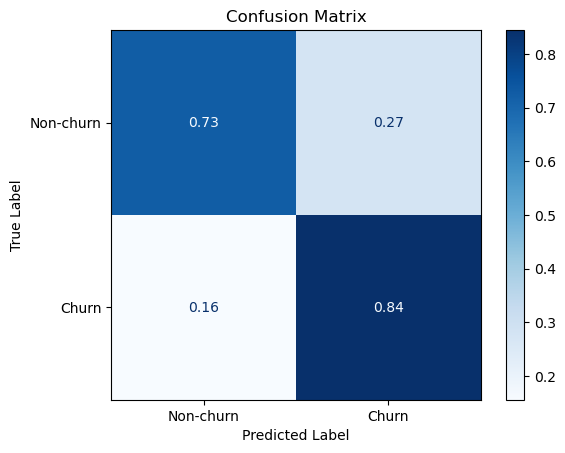

In [13]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class_model1, normalize='true')

# Define the class labels
labels = ['Non-churn', "Churn"]  # Replace with your class labels

# Create a confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 4 - Criando modelo otimizado

In [14]:
def optimize_model(preprocessor:ColumnTransformer,
                   model:RandomForestClassifier,
                   num_trials:int,
                   n_splits:int,
                   params_func:callable)->optuna.study:
    def objective(trial):
        avg_roc = 0
        avg_f1 = 0
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for tr, ts in kf.split(X, y):
            Xtr, Xvl = X.iloc[tr], X.iloc[ts]
            ytr, yvl = y.iloc[tr], y.iloc[ts]
            
            params = params_func(trial)

            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model(**params))])
            pipe.fit(Xtr, ytr)

            yvl_pred_proba = pipe.predict_proba(Xvl)[:,1]

            avg_roc += roc_auc_score(yvl, yvl_pred_proba)
            avg_f1 += f1_score(yvl, yvl_pred_proba > 0.5, average='macro')

        print('avg roc:', avg_roc / n_splits)
        print('avg f1:', avg_f1 / n_splits)

        
        return avg_roc / n_splits
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective,n_trials=num_trials)

    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)

    return study

def get_params(trial:optuna.trial)->dict:
    params = {
        "max_depth":trial.suggest_int("max_depth",7,8,log=True),
        "min_samples_split":trial.suggest_int("min_samples_split",2,5,log=True),
        "n_estimators":trial.suggest_int("n_estimators",520,600,log=True),
        "criterion":trial.suggest_categorical("criterion",["gini", "entropy", "log_loss"],),
        "class_weight":trial.suggest_categorical("class_weight",["balanced", "balanced_subsample"]),
        "random_state":82

    }
    return params

In [15]:
study = optimize_model(preprocessor=preprocessor,model=RandomForestClassifier,num_trials=10,n_splits=5,params_func=get_params)
best_params = study.best_params

[I 2024-03-20 12:48:47,753] A new study created in memory with name: no-name-1c5c1196-532b-420e-a498-e00911228fc8
[I 2024-03-20 12:49:02,559] Trial 0 finished with value: 0.8468667270090947 and parameters: {'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 534, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8468667270090947.


avg roc: 0.8468667270090947
avg f1: 0.7274774699090949


[I 2024-03-20 12:49:23,014] Trial 1 finished with value: 0.8457976211751589 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 526, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8468667270090947.


avg roc: 0.8457976211751589
avg f1: 0.7317995834024134


[I 2024-03-20 12:49:40,868] Trial 2 finished with value: 0.8469819333288477 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 548, 'criterion': 'entropy', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.8469819333288477
avg f1: 0.728857524085152


[I 2024-03-20 12:50:06,826] Trial 3 finished with value: 0.8466128563775349 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 531, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.8466128563775349
avg f1: 0.7286096250785308


[I 2024-03-20 12:50:25,102] Trial 4 finished with value: 0.8468072085341587 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 574, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.8468072085341587
avg f1: 0.726427544541504


[I 2024-03-20 12:50:49,839] Trial 5 finished with value: 0.846390446873819 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 598, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.846390446873819
avg f1: 0.7310731228656653


[I 2024-03-20 12:51:02,415] Trial 6 finished with value: 0.8464007064348461 and parameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 578, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.8464007064348461
avg f1: 0.7283400574523297


[I 2024-03-20 12:51:21,640] Trial 7 finished with value: 0.8467623229643536 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 594, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.8467623229643536
avg f1: 0.7301678223904643


[I 2024-03-20 12:51:42,154] Trial 8 finished with value: 0.8469578937587467 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 555, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.8469578937587467
avg f1: 0.7293640704695401


[I 2024-03-20 12:52:01,251] Trial 9 finished with value: 0.8467179946641942 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'n_estimators': 543, 'criterion': 'log_loss', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8469819333288477.


avg roc: 0.8467179946641942
avg f1: 0.7312320534818187
Number of finished trials: 10
Best trial: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 548, 'criterion': 'entropy', 'class_weight': 'balanced'}


In [16]:
# Define the pipeline for opt model
# Create the column transformer
preprocessor_for_bm = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES)
        ],
)

model_best_params = best_params
model_best_params["random_state"] = 82

# Define the pipeline
pipeline_for_bm = Pipeline(steps=[
    ('preprocessor', preprocessor_for_bm),  # Preprocessing (imputation + one-hot encoding)
    ('model', RandomForestClassifier(**model_best_params))  # Model
])

# Fit the pipeline to the training data
pipeline_for_bm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['fundação_da_empresa',
                                                   'meses_de_permanência',
                                                   'receita_mensal',
                                                   'receita_total',
                                                   'is_possuicontador_null',
                                                   'is_receita_total_null',
                                                   'qty_poucouso',
                                                   'qty_usofrequente',
                                                   'is_receita_mensal_maior_ou_igual_70']),
                                                 ('cat', OneHotEncoder(),
                                                  ['tipo_de_empresa',
                                                   'p...
                                                   'frequência_de_utilização_de_feature_do_sistema_relatórios',
                                                   'frequência_de_utilização_de_feature_do_sistema_utilização_de_apis_de_integração',
                                                   'contrato', 'emite_boletos',
                                                   'tipo_de_pagamento',
                                                   'clf_meses_de_permanência'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=8,
                                        min_samples_split=5, n_estimators=548,
                                        random_state=82))])

Precision-Recall AUC: 0.6973842843366835
classification_report
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1036
           1       0.57      0.80      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.79      0.75      1409
weighted avg       0.82      0.79      0.80      1409


Best F1-score: 0.6659217877094973 at threshold 0.5230618563773725


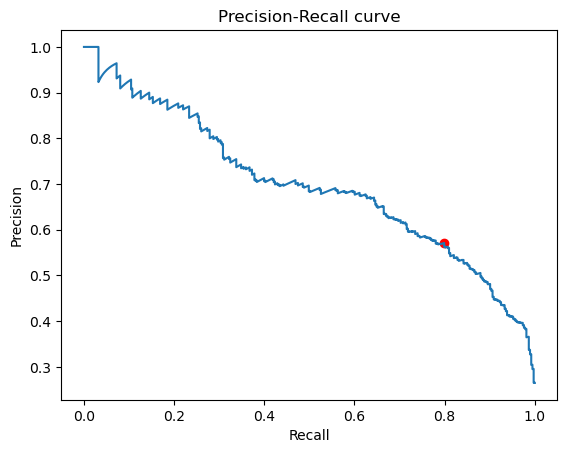

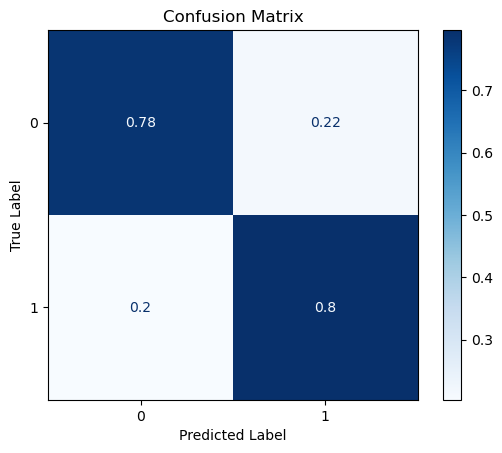

0.5230618563773725

In [17]:
y_pred_proba_bm = pipeline_for_bm.predict_proba(X_test)[:,1]
best_th = evaluate_metrics(y_test=y_test,y_pred=y_pred_proba_bm,normalize='true')
best_th

## 5 - Feature Selection


In [18]:
# model with best_params 

model_for_fs = RandomForestClassifier(**model_best_params)

Xt = preprocessor.transform(X)

# Apply feature selection
fs = RFECV(
    estimator=model_for_fs,
    step=1,
    min_features_to_select=int(Xt.shape[1]*0.6),
    scoring="roc_auc",
    cv=5,
    importance_getter="feature_importances_"
)
fs.fit(Xt,y)

RFECV(cv=5,
      estimator=RandomForestClassifier(class_weight='balanced',
                                       criterion='entropy', max_depth=8,
                                       min_samples_split=5, n_estimators=548,
                                       random_state=82),
      importance_getter='feature_importances_', min_features_to_select=32,
      scoring='roc_auc')

In [19]:
output_feature_names = preprocessor.get_feature_names_out()
print("Quantidade de features de entrada:",Xt.shape[1])
print("Quantidade de features selecionadas:",fs.n_features_)
print("Visualizando ranking das features:")
feat_ranking = pd.Series(fs.ranking_,index=output_feature_names)
feat_ranking.sort_values()

Quantidade de features de entrada: 54
Quantidade de features selecionadas: 40
Visualizando ranking das features:


num__fundação_da_empresa                                                                                1
cat__clf_meses_de_permanência_Maior que 36 meses                                                        1
cat__frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal_Pouco uso                    1
cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Nunca utilizou                  1
cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Pouco uso                       1
cat__frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas_Pouco uso                          1
cat__frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas_Uso frequente                      1
cat__frequência_de_utilização_de_feature_do_sistema_relatórios_Nunca utilizou                           1
cat__frequência_de_utilização_de_feature_do_sistema_relatórios_Uso frequente                            1
cat__frequência_de_utilização_de_feature_do_si

In [20]:
print("Features removidas")
rm_feats = set(output_feature_names).difference(set(output_feature_names[fs.support_]))
rm_feats = list(rm_feats)
rm_feats

Features removidas


['num__is_possuicontador_null',
 'cat__tipo_de_empresa_Pequena empresa',
 'cat__possuicontador_nan',
 'cat__frequência_de_utilização_de_feature_do_sistema_relatórios_Pouco uso',
 'cat__funcionários_6 ou mais funcionários',
 'cat__tipo_de_pagamento_Boleto - mês a mês',
 'cat__clf_meses_de_permanência_Entre 3 a 12 meses',
 'cat__frequência_de_utilização_de_feature_do_sistema_módulo_de_vendas_Nunca utilizou',
 'num__is_receita_total_null',
 'cat__frequência_de_utilização_de_feature_do_sistema_integração_bancária_Uso frequente',
 'cat__utiliza_serviços_financeiros_Não',
 'cat__utiliza_serviços_financeiros_Sim',
 'cat__frequência_de_utilização_de_feature_do_sistema_emissão_de_nota_fiscal_Uso frequente',
 'cat__possui_mais_de_um_sócio_Não']

In [21]:
# Avaliando mudança geral 

arr_selected_features = fs.support_

preprocessor_for_fs = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), NUM_FEATURES),
        ('cat', OneHotEncoder(), CAT_FEATURES),
        ],
)

col_selector = ColumnTransformer(
    transformers=[("select_cols","passthrough",arr_selected_features)]
)

pipeline_with_fs = Pipeline(steps=[
    ("column_transformations",preprocessor_for_fs),
    ("select_fs_columns",col_selector),
    ("model",RandomForestClassifier(**model_best_params))
])
pipeline_with_fs.fit(X_train,y_train)

Pipeline(steps=[('column_transformations',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['fundação_da_empresa',
                                                   'meses_de_permanência',
                                                   'receita_mensal',
                                                   'receita_total',
                                                   'is_possuicontador_null',
                                                   'is_receita_total_null',
                                                   'qty_poucouso',
                                                   'qty_usofrequente',
                                                   'is_receita_mensal_maior_ou_igual_70']),
                                                 ('cat', OneHotEncoder(),
                                                  ['tipo_de_e...
        True, False, False,  True, False,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True]))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=8,
                                        min_samples_split=5, n_estimators=548,
                                        random_state=82))])

Precision-Recall AUC: 0.6965473559794801
classification_report
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1036
           1       0.63      0.70      0.66       373

    accuracy                           0.81      1409
   macro avg       0.76      0.77      0.76      1409
weighted avg       0.82      0.81      0.81      1409


Best F1-score: 0.6615969581749049 at threshold 0.6010194795186382


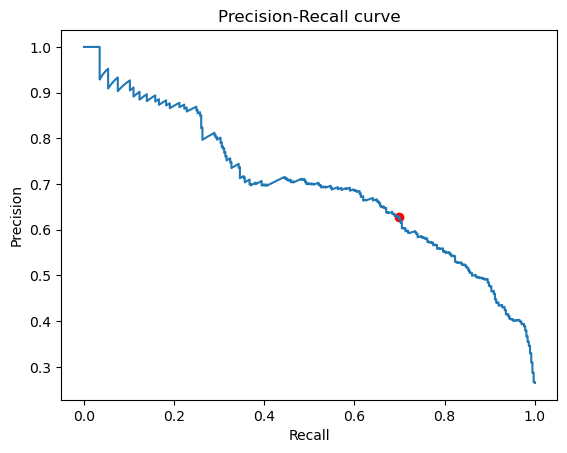

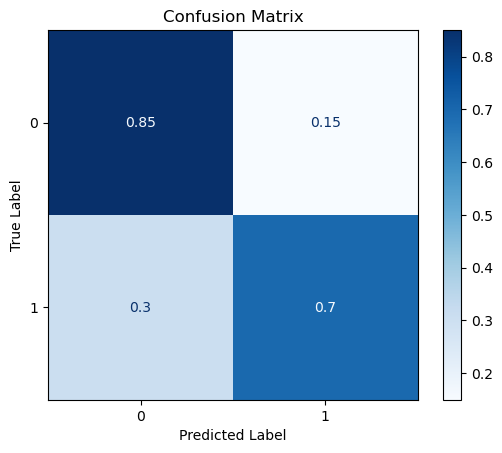

0.6010194795186382

In [22]:
y_pred_proba_fs = pipeline_with_fs.predict_proba(X_test)[:,1]

evaluate_metrics(y_test=y_test,y_pred=y_pred_proba_fs,normalize='true')

## 6 - Save best model

In [ ]:
OUTPUT_PATH = Path("./config")

num_features = [str.encode(col,encoding="ISO-8859-1") for col in NUM_FEATURES]
cat_features = [str.encode(col,encoding="ISO-8859-1") for col in CAT_FEATURES]

MODEL_PARAMETERS = {
    "model_name":"random_forest_clf_for_churn",
    "model_version":1,
    "model_parameters":{
        "fit_params":model_best_params,
        "predict_params":{"decision_threshold":float(best_th)}},
    "model_features":{"NUM_FEATURES":num_features,"CAT_FEATURES":cat_features},
    "model_target":"churn"
}


if OUTPUT_PATH.is_dir():
    with open(f"{OUTPUT_PATH}/model_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)
else:
    OUTPUT_PATH.mkdir(exist_ok=True,parents=True)
    with open(f"{OUTPUT_PATH}/model_config.yaml","w") as f:
        yaml.dump(MODEL_PARAMETERS,f)

## 7 - Conclusão